# Load Timeseries data to Redis Timeseries and chart with seaborn

Simulating 1 year's worth of captured Strava API data at 1 hour intervals

This script consists of two parts:

* Connect
    * Check for active Redis connection
    * Note: will require [Redis Timeseries Module](https://oss.redislabs.com/redistimeseries/)
    
* Generate
    * Generating an example timeseries data with Pandas
    * Adding to Redis using timeseries module
    
* Plot
    * Extracting from Redis using timeseries aggregate
    * Plotting with seaborn

In [25]:
import numpy as np
import pandas as pd
from numpy import sqrt
import redis
import random
import arrow
import datetime

import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from redis.exceptions import (ResponseError as RedisResponseError)

In [26]:
# Connect: Make sure Redis is running

try:
    host = 'localhost'
    port = 6379
    redis_obj = redis.Redis(host=host, port=port, password="", db=1)
    redis_obj.ping()
    
    print(f'Redis available at {host}:{port}')
    redis_obj.flushdb()
    connected = True
except redis.ConnectionError as e:
    print(f'Redis could not be accessed at {host}:{port}')
    connected = False


Redis available at localhost:6379


In [27]:
# Generate timeseries data and add to Redis

if connected:
    timestamps = []
    key = "ts:metric_strava"

    # Simulate 1 year of data at hourly intervals
    periods = 52 * 7 * 24
    start_date = '2018-01-01 00:00:00'

    tidx = pd.date_range(start_date, periods=periods, freq="H")

    # Loop over generated datetimes and generate 
    # a new random value for km cycled for every week
    # incremented from the previous week's random value
    rnd_val = random.randrange(10, 15)
    for hour_inc, dt in enumerate(tidx):
        # if every 'months worth of hourly increments'
        if hour_inc % (4 * 7* 24) == 0:
            rnd_val = random.randrange(rnd_val, rnd_val+random.randrange(3,5))
        ts = arrow.get(dt).timestamp

        try:
            redis_obj.execute_command("ts.add", key, ts, rnd_val )
        except (RedisResponseError):
            print('Older timeseries data cannot be inserted. Truncating all key data and trying again..')


    print(f'Timeseries data added to Redis key: {key}') 

Timeseries data added to Redis key: ts:metric_strava


In [28]:
# Get the data out

values = redis_obj.execute_command(
    "TS.RANGE",
    key,
    arrow.get(tidx[0]).timestamp,
    arrow.get(tidx[-1]).timestamp,
    "AGGREGATION",
    "avg",
    (3600))
print(values)

[[1514764800, b'14'], [1514768400, b'14'], [1514772000, b'14'], [1514775600, b'14'], [1514779200, b'14'], [1514782800, b'14'], [1514786400, b'14'], [1514790000, b'14'], [1514793600, b'14'], [1514797200, b'14'], [1514800800, b'14'], [1514804400, b'14'], [1514808000, b'14'], [1514811600, b'14'], [1514815200, b'14'], [1514818800, b'14'], [1514822400, b'14'], [1514826000, b'14'], [1514829600, b'14'], [1514833200, b'14'], [1514836800, b'14'], [1514840400, b'14'], [1514844000, b'14'], [1514847600, b'14'], [1514851200, b'14'], [1514854800, b'14'], [1514858400, b'14'], [1514862000, b'14'], [1514865600, b'14'], [1514869200, b'14'], [1514872800, b'14'], [1514876400, b'14'], [1514880000, b'14'], [1514883600, b'14'], [1514887200, b'14'], [1514890800, b'14'], [1514894400, b'14'], [1514898000, b'14'], [1514901600, b'14'], [1514905200, b'14'], [1514908800, b'14'], [1514912400, b'14'], [1514916000, b'14'], [1514919600, b'14'], [1514923200, b'14'], [1514926800, b'14'], [1514930400, b'14'], [1514934000,

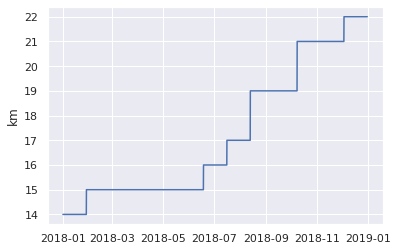

In [29]:
# Plot it with seaborn
sns.set()

df = DataFrame.from_records(values, columns=("timestamps", "km"))

sns.lineplot(x=pd.Series(tidx), y=pd.to_numeric(df["km"]))